In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/100 [00:02<?, ?it/s]


torch.Size([6, 16, 315, 315])

In [3]:
# from tqdm import tqdm

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.batch_size,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
# # train_nshuffle_loader = DataLoader(
# #     train_nshuffle_dataset,
# #     batch_size=1,
# #     shuffle=True,
# #     drop_last=True,
# #     pin_memory=True,
# #     num_workers=CFG.num_workers,
# # )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )

# for data in tqdm(train_loader):
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

# normalized_tomogram.shape

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

In [5]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [7]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 256, 256])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
# criterion = nn.CrossEntropyLoss(
#     #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
# )
criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([6, 16, 320, 320])

In [12]:
best_model = None
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()
            pred = model(preprocess_tensor(normalized_tomogram))
            loss = seg_loss(pred, segmentation_map)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            pred = model(preprocess_tensor(normalized_tomogram))
            loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in CFG.train_exp_names[:5]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=True
        )
        pred_df = inference2pos(
            pred_segmask=inferenced_array.argmax(0), exp_name=exp_name
        )
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])

        train_nshuffle_pred_tomogram[exp_name] = inferenced_array

        score_ = score(
            pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
        )
        train_mean_scores.append(score_)

    # print("train_mean_scores", np.mean(train_mean_scores))

    for exp_name in CFG.valid_exp_names:
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=True
        )
        pred_df = inference2pos(
            pred_segmask=inferenced_array.argmax(0), exp_name=exp_name
        )
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])

        valid_pred_tomogram[exp_name] = inferenced_array

        score_ = score(
            pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
        )
        valid_mean_scores.append(score_)

    # print("valid_mean_scores", np.mean(valid_mean_scores))

    if np.mean(valid_mean_scores) > best_score:
        best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{np.mean(valid_mean_scores):.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(np.mean(valid_mean_scores))

Epoch 1/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s, loss=0.8760]


train-epoch-loss:0.9088 valid-epoch-loss:0.8760 train-beta4-score:0.0394 valid-beta4-score:0.0104


Epoch 2/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=0.7678]


train-epoch-loss:0.8520 valid-epoch-loss:0.7678 train-beta4-score:0.0305 valid-beta4-score:0.0179


Epoch 3/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=0.7205]


train-epoch-loss:0.7970 valid-epoch-loss:0.7205 train-beta4-score:0.0738 valid-beta4-score:0.0532


Epoch 4/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6688]


train-epoch-loss:0.7775 valid-epoch-loss:0.6688 train-beta4-score:0.1865 valid-beta4-score:0.1727


Epoch 5/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.6795]


train-epoch-loss:0.7625 valid-epoch-loss:0.6795 train-beta4-score:0.1482 valid-beta4-score:0.1522


Epoch 6/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.6149]


train-epoch-loss:0.7434 valid-epoch-loss:0.6149 train-beta4-score:0.2655 valid-beta4-score:0.2461


Epoch 7/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6114]


train-epoch-loss:0.7310 valid-epoch-loss:0.6114 train-beta4-score:0.3060 valid-beta4-score:0.2397


Epoch 8/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6891]


train-epoch-loss:0.7201 valid-epoch-loss:0.6891 train-beta4-score:0.2314 valid-beta4-score:0.2018


Epoch 9/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.6700]


train-epoch-loss:0.7272 valid-epoch-loss:0.6700 train-beta4-score:0.3933 valid-beta4-score:0.2853


Epoch 10/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.6989]


train-epoch-loss:0.7183 valid-epoch-loss:0.6989 train-beta4-score:0.4675 valid-beta4-score:0.3274


Epoch 11/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.5996]


train-epoch-loss:0.7199 valid-epoch-loss:0.5996 train-beta4-score:0.4124 valid-beta4-score:0.3371


Epoch 12/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.5471]


train-epoch-loss:0.6875 valid-epoch-loss:0.5471 train-beta4-score:0.4963 valid-beta4-score:0.3519


Epoch 13/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6894]


train-epoch-loss:0.6781 valid-epoch-loss:0.6894 train-beta4-score:0.5115 valid-beta4-score:0.3412


Epoch 14/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5979]


train-epoch-loss:0.6918 valid-epoch-loss:0.5979 train-beta4-score:0.4838 valid-beta4-score:0.3271


Epoch 15/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.6559]


train-epoch-loss:0.6642 valid-epoch-loss:0.6559 train-beta4-score:0.6408 valid-beta4-score:0.4419


Epoch 16/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.5447]


train-epoch-loss:0.6476 valid-epoch-loss:0.5447 train-beta4-score:0.5208 valid-beta4-score:0.3403


Epoch 17/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.6486]


train-epoch-loss:0.6308 valid-epoch-loss:0.6486 train-beta4-score:0.5479 valid-beta4-score:0.3774


Epoch 18/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.5546]


train-epoch-loss:0.5781 valid-epoch-loss:0.5546 train-beta4-score:0.3896 valid-beta4-score:0.2626


Epoch 19/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6291]


train-epoch-loss:0.6335 valid-epoch-loss:0.6291 train-beta4-score:0.4994 valid-beta4-score:0.3427


Epoch 20/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.6395]


train-epoch-loss:0.6142 valid-epoch-loss:0.6395 train-beta4-score:0.4672 valid-beta4-score:0.3271


Epoch 21/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.7171]


train-epoch-loss:0.6272 valid-epoch-loss:0.7171 train-beta4-score:0.5517 valid-beta4-score:0.3320


Epoch 22/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5072]


train-epoch-loss:0.6090 valid-epoch-loss:0.5072 train-beta4-score:0.6428 valid-beta4-score:0.3886


Epoch 23/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4769]


train-epoch-loss:0.5599 valid-epoch-loss:0.4769 train-beta4-score:0.6664 valid-beta4-score:0.3818


Epoch 24/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5035]


train-epoch-loss:0.6064 valid-epoch-loss:0.5035 train-beta4-score:0.6648 valid-beta4-score:0.3760


Epoch 25/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.6582]


train-epoch-loss:0.6203 valid-epoch-loss:0.6582 train-beta4-score:0.5897 valid-beta4-score:0.3581


Epoch 26/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5012]


train-epoch-loss:0.6322 valid-epoch-loss:0.5012 train-beta4-score:0.4873 valid-beta4-score:0.3535


Epoch 27/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.6405]


train-epoch-loss:0.6210 valid-epoch-loss:0.6405 train-beta4-score:0.5790 valid-beta4-score:0.3356


Epoch 28/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.4952]


train-epoch-loss:0.5555 valid-epoch-loss:0.4952 train-beta4-score:0.6929 valid-beta4-score:0.4232


Epoch 29/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.4582]


train-epoch-loss:0.6051 valid-epoch-loss:0.4582 train-beta4-score:0.6837 valid-beta4-score:0.4053


Epoch 30/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5373]


train-epoch-loss:0.5666 valid-epoch-loss:0.5373 train-beta4-score:0.8055 valid-beta4-score:0.4969


Epoch 31/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.6253]


train-epoch-loss:0.6006 valid-epoch-loss:0.6253 train-beta4-score:0.7076 valid-beta4-score:0.4187


Epoch 32/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.8315]


train-epoch-loss:0.5721 valid-epoch-loss:0.8315 train-beta4-score:0.7421 valid-beta4-score:0.4092


Epoch 33/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6670]


train-epoch-loss:0.5995 valid-epoch-loss:0.6670 train-beta4-score:0.7452 valid-beta4-score:0.4538


Epoch 34/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5529]


train-epoch-loss:0.5533 valid-epoch-loss:0.5529 train-beta4-score:0.7312 valid-beta4-score:0.4379


Epoch 35/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=0.6405]


train-epoch-loss:0.5598 valid-epoch-loss:0.6405 train-beta4-score:0.7455 valid-beta4-score:0.4306


Epoch 36/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5175]


train-epoch-loss:0.5744 valid-epoch-loss:0.5175 train-beta4-score:0.7352 valid-beta4-score:0.4297


Epoch 37/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.6740]


train-epoch-loss:0.5892 valid-epoch-loss:0.6740 train-beta4-score:0.7886 valid-beta4-score:0.4696


Epoch 38/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.6370]


train-epoch-loss:0.6027 valid-epoch-loss:0.6370 train-beta4-score:0.7643 valid-beta4-score:0.4340


Epoch 39/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.6738]


train-epoch-loss:0.5535 valid-epoch-loss:0.6738 train-beta4-score:0.5241 valid-beta4-score:0.3111


Epoch 40/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6115]


train-epoch-loss:0.5833 valid-epoch-loss:0.6115 train-beta4-score:0.7359 valid-beta4-score:0.4319


Epoch 41/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5251]


train-epoch-loss:0.5466 valid-epoch-loss:0.5251 train-beta4-score:0.7071 valid-beta4-score:0.4412


Epoch 42/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4694]


train-epoch-loss:0.5351 valid-epoch-loss:0.4694 train-beta4-score:0.5946 valid-beta4-score:0.3844


Epoch 43/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5782]


train-epoch-loss:0.5328 valid-epoch-loss:0.5782 train-beta4-score:0.8756 valid-beta4-score:0.5430


Epoch 44/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4973]


train-epoch-loss:0.5028 valid-epoch-loss:0.4973 train-beta4-score:0.4589 valid-beta4-score:0.3407


Epoch 45/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.5320]


train-epoch-loss:0.4941 valid-epoch-loss:0.5320 train-beta4-score:0.7196 valid-beta4-score:0.4536


Epoch 46/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5649]


train-epoch-loss:0.4522 valid-epoch-loss:0.5649 train-beta4-score:0.7154 valid-beta4-score:0.4451


Epoch 47/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5522]


train-epoch-loss:0.4629 valid-epoch-loss:0.5522 train-beta4-score:0.5931 valid-beta4-score:0.4178


Epoch 48/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.4381]


train-epoch-loss:0.4245 valid-epoch-loss:0.4381 train-beta4-score:0.8821 valid-beta4-score:0.5538


Epoch 49/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.3000]


train-epoch-loss:0.3967 valid-epoch-loss:0.3000 train-beta4-score:0.8198 valid-beta4-score:0.4994


Epoch 50/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4434]


train-epoch-loss:0.3839 valid-epoch-loss:0.4434 train-beta4-score:0.7302 valid-beta4-score:0.4256


Epoch 51/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4811]


train-epoch-loss:0.3985 valid-epoch-loss:0.4811 train-beta4-score:0.5716 valid-beta4-score:0.4080


Epoch 52/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.3207]


train-epoch-loss:0.3286 valid-epoch-loss:0.3207 train-beta4-score:0.7093 valid-beta4-score:0.4897


Epoch 53/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4121]


train-epoch-loss:0.3292 valid-epoch-loss:0.4121 train-beta4-score:0.6624 valid-beta4-score:0.4459


Epoch 54/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.3661]


train-epoch-loss:0.4020 valid-epoch-loss:0.3661 train-beta4-score:0.4932 valid-beta4-score:0.3600


Epoch 55/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.3789]


train-epoch-loss:0.3776 valid-epoch-loss:0.3789 train-beta4-score:0.7913 valid-beta4-score:0.4974


Epoch 56/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3665]


train-epoch-loss:0.3638 valid-epoch-loss:0.3665 train-beta4-score:0.7962 valid-beta4-score:0.5286


Epoch 57/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.4758]


train-epoch-loss:0.4004 valid-epoch-loss:0.4758 train-beta4-score:0.6349 valid-beta4-score:0.4070


Epoch 58/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s, loss=0.4840]


train-epoch-loss:0.3801 valid-epoch-loss:0.4840 train-beta4-score:0.8387 valid-beta4-score:0.5281


Epoch 59/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4724]


train-epoch-loss:0.3775 valid-epoch-loss:0.4724 train-beta4-score:0.7363 valid-beta4-score:0.4870


Epoch 60/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4325]


train-epoch-loss:0.3360 valid-epoch-loss:0.4325 train-beta4-score:0.8346 valid-beta4-score:0.5223


Epoch 61/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4898]


train-epoch-loss:0.3675 valid-epoch-loss:0.4898 train-beta4-score:0.8105 valid-beta4-score:0.4597


Epoch 62/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.3749]


train-epoch-loss:0.3643 valid-epoch-loss:0.3749 train-beta4-score:0.8413 valid-beta4-score:0.5199


Epoch 63/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4600]


train-epoch-loss:0.3306 valid-epoch-loss:0.4600 train-beta4-score:0.6823 valid-beta4-score:0.4789


Epoch 64/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.5653]


train-epoch-loss:0.3870 valid-epoch-loss:0.5653 train-beta4-score:0.6300 valid-beta4-score:0.3568


Epoch 65/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.3765]


train-epoch-loss:0.3541 valid-epoch-loss:0.3765 train-beta4-score:0.6664 valid-beta4-score:0.3636


Epoch 66/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5552]


train-epoch-loss:0.3632 valid-epoch-loss:0.5552 train-beta4-score:0.7501 valid-beta4-score:0.3921


Epoch 67/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5340]


train-epoch-loss:0.3791 valid-epoch-loss:0.5340 train-beta4-score:0.6412 valid-beta4-score:0.3720


Epoch 68/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.6106]


train-epoch-loss:0.3719 valid-epoch-loss:0.6106 train-beta4-score:0.5566 valid-beta4-score:0.3207


Epoch 69/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4903]


train-epoch-loss:0.3582 valid-epoch-loss:0.4903 train-beta4-score:0.7020 valid-beta4-score:0.3480


Epoch 70/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.3577]


train-epoch-loss:0.3473 valid-epoch-loss:0.3577 train-beta4-score:0.5820 valid-beta4-score:0.3184


Epoch 71/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.6059]


train-epoch-loss:0.3634 valid-epoch-loss:0.6059 train-beta4-score:0.6901 valid-beta4-score:0.3711


Epoch 72/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5981]


train-epoch-loss:0.3754 valid-epoch-loss:0.5981 train-beta4-score:0.6941 valid-beta4-score:0.3767


Epoch 73/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.3955]


train-epoch-loss:0.3858 valid-epoch-loss:0.3955 train-beta4-score:0.6224 valid-beta4-score:0.3680


Epoch 74/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.3911]


train-epoch-loss:0.3529 valid-epoch-loss:0.3911 train-beta4-score:0.7125 valid-beta4-score:0.3884


Epoch 75/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.5315]


train-epoch-loss:0.3680 valid-epoch-loss:0.5315 train-beta4-score:0.5721 valid-beta4-score:0.3049


Epoch 76/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.2826]


train-epoch-loss:0.3517 valid-epoch-loss:0.2826 train-beta4-score:0.7139 valid-beta4-score:0.4351


Epoch 77/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.6686]


train-epoch-loss:0.3460 valid-epoch-loss:0.6686 train-beta4-score:0.7336 valid-beta4-score:0.3812


Epoch 78/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.4874]


train-epoch-loss:0.3690 valid-epoch-loss:0.4874 train-beta4-score:0.5751 valid-beta4-score:0.3172


Epoch 79/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5600]


train-epoch-loss:0.3675 valid-epoch-loss:0.5600 train-beta4-score:0.6154 valid-beta4-score:0.3487


Epoch 80/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4541]


train-epoch-loss:0.3332 valid-epoch-loss:0.4541 train-beta4-score:0.6886 valid-beta4-score:0.3751


Epoch 81/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.3319]


train-epoch-loss:0.3687 valid-epoch-loss:0.3319 train-beta4-score:0.6302 valid-beta4-score:0.3393


Epoch 82/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5149]


train-epoch-loss:0.3563 valid-epoch-loss:0.5149 train-beta4-score:0.7213 valid-beta4-score:0.2771


Epoch 83/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.6422]


train-epoch-loss:0.3759 valid-epoch-loss:0.6422 train-beta4-score:0.7057 valid-beta4-score:0.4067


Epoch 84/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4938]


train-epoch-loss:0.3686 valid-epoch-loss:0.4938 train-beta4-score:0.5317 valid-beta4-score:0.3166


Epoch 85/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5527]


train-epoch-loss:0.3705 valid-epoch-loss:0.5527 train-beta4-score:0.5580 valid-beta4-score:0.3410


Epoch 86/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4697]


train-epoch-loss:0.3352 valid-epoch-loss:0.4697 train-beta4-score:0.6962 valid-beta4-score:0.3927


Epoch 87/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4673]


train-epoch-loss:0.3389 valid-epoch-loss:0.4673 train-beta4-score:0.7418 valid-beta4-score:0.3576


Epoch 88/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5529]


train-epoch-loss:0.3654 valid-epoch-loss:0.5529 train-beta4-score:0.6866 valid-beta4-score:0.3309


Epoch 89/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.4658]


train-epoch-loss:0.3589 valid-epoch-loss:0.4658 train-beta4-score:0.6335 valid-beta4-score:0.3414


Epoch 90/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.4416]


train-epoch-loss:0.3475 valid-epoch-loss:0.4416 train-beta4-score:0.6620 valid-beta4-score:0.3893


Epoch 91/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5997]


train-epoch-loss:0.3295 valid-epoch-loss:0.5997 train-beta4-score:0.7079 valid-beta4-score:0.3577


Epoch 92/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.6085]


train-epoch-loss:0.3373 valid-epoch-loss:0.6085 train-beta4-score:0.6227 valid-beta4-score:0.3422


Epoch 93/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4296]


train-epoch-loss:0.3825 valid-epoch-loss:0.4296 train-beta4-score:0.6393 valid-beta4-score:0.3717


Epoch 94/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.2705]


train-epoch-loss:0.3498 valid-epoch-loss:0.2705 train-beta4-score:0.5386 valid-beta4-score:0.3028


Epoch 95/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.2212]


train-epoch-loss:0.3611 valid-epoch-loss:0.2212 train-beta4-score:0.6412 valid-beta4-score:0.3832


Epoch 96/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.6917]


train-epoch-loss:0.3278 valid-epoch-loss:0.6917 train-beta4-score:0.6628 valid-beta4-score:0.3714


Epoch 97/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5416]


train-epoch-loss:0.3306 valid-epoch-loss:0.5416 train-beta4-score:0.6589 valid-beta4-score:0.3273


Epoch 98/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4060]


train-epoch-loss:0.3939 valid-epoch-loss:0.4060 train-beta4-score:0.5984 valid-beta4-score:0.3253


Epoch 99/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.6238]


train-epoch-loss:0.3514 valid-epoch-loss:0.6238 train-beta4-score:0.6680 valid-beta4-score:0.3808


Epoch 100/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3991]


train-epoch-loss:0.3551 valid-epoch-loss:0.3991 train-beta4-score:0.6661 valid-beta4-score:0.3483


Epoch 101/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.4761]


train-epoch-loss:0.3425 valid-epoch-loss:0.4761 train-beta4-score:0.6471 valid-beta4-score:0.3263


Epoch 102/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s, loss=0.5272]


train-epoch-loss:0.3349 valid-epoch-loss:0.5272 train-beta4-score:0.7188 valid-beta4-score:0.4363


Epoch 103/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.5082]


train-epoch-loss:0.3400 valid-epoch-loss:0.5082 train-beta4-score:0.6433 valid-beta4-score:0.3887


Epoch 104/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.5015]


train-epoch-loss:0.3370 valid-epoch-loss:0.5015 train-beta4-score:0.6930 valid-beta4-score:0.3821


Epoch 105/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5943]


train-epoch-loss:0.3844 valid-epoch-loss:0.5943 train-beta4-score:0.7100 valid-beta4-score:0.4329


Epoch 106/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4819]


train-epoch-loss:0.3370 valid-epoch-loss:0.4819 train-beta4-score:0.5705 valid-beta4-score:0.3236


Epoch 107/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.6667]


train-epoch-loss:0.3578 valid-epoch-loss:0.6667 train-beta4-score:0.6730 valid-beta4-score:0.4256


Epoch 108/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4492]


train-epoch-loss:0.3603 valid-epoch-loss:0.4492 train-beta4-score:0.7282 valid-beta4-score:0.4199


Epoch 109/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.4730]


train-epoch-loss:0.3449 valid-epoch-loss:0.4730 train-beta4-score:0.7196 valid-beta4-score:0.4113


Epoch 110/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.5598]


train-epoch-loss:0.3726 valid-epoch-loss:0.5598 train-beta4-score:0.5722 valid-beta4-score:0.3297


Epoch 111/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5018]


train-epoch-loss:0.3451 valid-epoch-loss:0.5018 train-beta4-score:0.7340 valid-beta4-score:0.4450


Epoch 112/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.6996]


train-epoch-loss:0.3687 valid-epoch-loss:0.6996 train-beta4-score:0.6740 valid-beta4-score:0.3837


Epoch 113/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5908]


train-epoch-loss:0.3310 valid-epoch-loss:0.5908 train-beta4-score:0.5823 valid-beta4-score:0.3285


Epoch 114/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5873]


train-epoch-loss:0.3211 valid-epoch-loss:0.5873 train-beta4-score:0.6488 valid-beta4-score:0.3571


Epoch 115/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.5055]


train-epoch-loss:0.3295 valid-epoch-loss:0.5055 train-beta4-score:0.7198 valid-beta4-score:0.3809


Epoch 116/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.5974]


train-epoch-loss:0.3445 valid-epoch-loss:0.5974 train-beta4-score:0.6743 valid-beta4-score:0.3546


Epoch 117/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5509]


train-epoch-loss:0.3135 valid-epoch-loss:0.5509 train-beta4-score:0.7030 valid-beta4-score:0.4389


Epoch 118/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.4238]


train-epoch-loss:0.3434 valid-epoch-loss:0.4238 train-beta4-score:0.7220 valid-beta4-score:0.3898


Epoch 119/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3156]


train-epoch-loss:0.3283 valid-epoch-loss:0.3156 train-beta4-score:0.6378 valid-beta4-score:0.3752


Epoch 120/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.2617]


train-epoch-loss:0.3818 valid-epoch-loss:0.2617 train-beta4-score:0.4617 valid-beta4-score:0.3090


Epoch 121/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s, loss=0.4144]


train-epoch-loss:0.3761 valid-epoch-loss:0.4144 train-beta4-score:0.6844 valid-beta4-score:0.3800


Epoch 122/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4416]


train-epoch-loss:0.3525 valid-epoch-loss:0.4416 train-beta4-score:0.6338 valid-beta4-score:0.3413


Epoch 123/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4248]


train-epoch-loss:0.3404 valid-epoch-loss:0.4248 train-beta4-score:0.7011 valid-beta4-score:0.3479


Epoch 124/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.2313]


train-epoch-loss:0.3692 valid-epoch-loss:0.2313 train-beta4-score:0.5989 valid-beta4-score:0.3341


Epoch 125/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.2362]


train-epoch-loss:0.3388 valid-epoch-loss:0.2362 train-beta4-score:0.6729 valid-beta4-score:0.3709


Epoch 126/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.2258]


train-epoch-loss:0.3386 valid-epoch-loss:0.2258 train-beta4-score:0.6944 valid-beta4-score:0.3253


Epoch 127/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.4566]


train-epoch-loss:0.3407 valid-epoch-loss:0.4566 train-beta4-score:0.6910 valid-beta4-score:0.3461


Epoch 128/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.5874]


train-epoch-loss:0.3650 valid-epoch-loss:0.5874 train-beta4-score:0.6357 valid-beta4-score:0.3367


Epoch 129/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4349]


train-epoch-loss:0.3118 valid-epoch-loss:0.4349 train-beta4-score:0.6978 valid-beta4-score:0.3870


Epoch 130/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.4634]


train-epoch-loss:0.3738 valid-epoch-loss:0.4634 train-beta4-score:0.4719 valid-beta4-score:0.2296


Epoch 131/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5185]


train-epoch-loss:0.3950 valid-epoch-loss:0.5185 train-beta4-score:0.6468 valid-beta4-score:0.2861


Epoch 132/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5299]


train-epoch-loss:0.3835 valid-epoch-loss:0.5299 train-beta4-score:0.5611 valid-beta4-score:0.2704


Epoch 133/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6763]


train-epoch-loss:0.3847 valid-epoch-loss:0.6763 train-beta4-score:0.6276 valid-beta4-score:0.3203


Epoch 134/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4251]


train-epoch-loss:0.4449 valid-epoch-loss:0.4251 train-beta4-score:0.5055 valid-beta4-score:0.2640


Epoch 135/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3527]


train-epoch-loss:0.3831 valid-epoch-loss:0.3527 train-beta4-score:0.5926 valid-beta4-score:0.2680


Epoch 136/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5779]


train-epoch-loss:0.3828 valid-epoch-loss:0.5779 train-beta4-score:0.5450 valid-beta4-score:0.2944


Epoch 137/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5943]


train-epoch-loss:0.3897 valid-epoch-loss:0.5943 train-beta4-score:0.5969 valid-beta4-score:0.3333


Epoch 138/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5438]


train-epoch-loss:0.4240 valid-epoch-loss:0.5438 train-beta4-score:0.6464 valid-beta4-score:0.3494


Epoch 139/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4944]


train-epoch-loss:0.3758 valid-epoch-loss:0.4944 train-beta4-score:0.6206 valid-beta4-score:0.3569


Epoch 140/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3953]


train-epoch-loss:0.3457 valid-epoch-loss:0.3953 train-beta4-score:0.5512 valid-beta4-score:0.3423


Epoch 141/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4926]


train-epoch-loss:0.3409 valid-epoch-loss:0.4926 train-beta4-score:0.7416 valid-beta4-score:0.3741


Epoch 142/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.6471]


train-epoch-loss:0.3277 valid-epoch-loss:0.6471 train-beta4-score:0.7196 valid-beta4-score:0.3658


Epoch 143/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4512]


train-epoch-loss:0.3488 valid-epoch-loss:0.4512 train-beta4-score:0.6864 valid-beta4-score:0.3790


Epoch 144/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5200]


train-epoch-loss:0.3700 valid-epoch-loss:0.5200 train-beta4-score:0.6219 valid-beta4-score:0.3649


Epoch 145/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.5993]


train-epoch-loss:0.3708 valid-epoch-loss:0.5993 train-beta4-score:0.6791 valid-beta4-score:0.3542


Epoch 146/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5911]


train-epoch-loss:0.3496 valid-epoch-loss:0.5911 train-beta4-score:0.6631 valid-beta4-score:0.3704


Epoch 147/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.3156]


train-epoch-loss:0.3307 valid-epoch-loss:0.3156 train-beta4-score:0.7279 valid-beta4-score:0.3960


Epoch 148/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5923]


train-epoch-loss:0.3037 valid-epoch-loss:0.5923 train-beta4-score:0.6493 valid-beta4-score:0.3624


Epoch 149/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4158]


train-epoch-loss:0.3476 valid-epoch-loss:0.4158 train-beta4-score:0.5802 valid-beta4-score:0.3298


Epoch 150/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.4352]


train-epoch-loss:0.3191 valid-epoch-loss:0.4352 train-beta4-score:0.6395 valid-beta4-score:0.3653


Epoch 151/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5590]


train-epoch-loss:0.3189 valid-epoch-loss:0.5590 train-beta4-score:0.7455 valid-beta4-score:0.4188


Epoch 152/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.3709]


train-epoch-loss:0.3673 valid-epoch-loss:0.3709 train-beta4-score:0.6974 valid-beta4-score:0.3767


Epoch 153/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5245]


train-epoch-loss:0.3826 valid-epoch-loss:0.5245 train-beta4-score:0.7025 valid-beta4-score:0.4072


Epoch 154/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.3771]


train-epoch-loss:0.3505 valid-epoch-loss:0.3771 train-beta4-score:0.6773 valid-beta4-score:0.3770


Epoch 155/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.5577]


train-epoch-loss:0.3607 valid-epoch-loss:0.5577 train-beta4-score:0.6713 valid-beta4-score:0.2991


Epoch 156/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4375]


train-epoch-loss:0.3450 valid-epoch-loss:0.4375 train-beta4-score:0.7036 valid-beta4-score:0.4128


Epoch 157/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.3049]


train-epoch-loss:0.3472 valid-epoch-loss:0.3049 train-beta4-score:0.7119 valid-beta4-score:0.3549


Epoch 158/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5608]


train-epoch-loss:0.3516 valid-epoch-loss:0.5608 train-beta4-score:0.7067 valid-beta4-score:0.4060


Epoch 159/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5610]


train-epoch-loss:0.3314 valid-epoch-loss:0.5610 train-beta4-score:0.7051 valid-beta4-score:0.3686


Epoch 160/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.3282]


train-epoch-loss:0.3218 valid-epoch-loss:0.3282 train-beta4-score:0.6920 valid-beta4-score:0.3572


Epoch 161/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4720]


train-epoch-loss:0.3381 valid-epoch-loss:0.4720 train-beta4-score:0.6630 valid-beta4-score:0.3331


Epoch 162/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3835]


train-epoch-loss:0.3344 valid-epoch-loss:0.3835 train-beta4-score:0.6621 valid-beta4-score:0.3349


Epoch 163/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4510]


train-epoch-loss:0.3501 valid-epoch-loss:0.4510 train-beta4-score:0.6753 valid-beta4-score:0.3589


Epoch 164/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5412]


train-epoch-loss:0.3561 valid-epoch-loss:0.5412 train-beta4-score:0.6218 valid-beta4-score:0.3617


Epoch 165/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5877]


train-epoch-loss:0.3509 valid-epoch-loss:0.5877 train-beta4-score:0.7232 valid-beta4-score:0.4173


Epoch 166/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4469]


train-epoch-loss:0.3125 valid-epoch-loss:0.4469 train-beta4-score:0.6451 valid-beta4-score:0.3357


Epoch 167/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.3146]


train-epoch-loss:0.3281 valid-epoch-loss:0.3146 train-beta4-score:0.6790 valid-beta4-score:0.3713


Epoch 168/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5520]


train-epoch-loss:0.3552 valid-epoch-loss:0.5520 train-beta4-score:0.7464 valid-beta4-score:0.4288


Epoch 169/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4804]


train-epoch-loss:0.3478 valid-epoch-loss:0.4804 train-beta4-score:0.6798 valid-beta4-score:0.4104


Epoch 170/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=0.5321]


train-epoch-loss:0.3374 valid-epoch-loss:0.5321 train-beta4-score:0.7414 valid-beta4-score:0.4211


Epoch 171/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5160]


train-epoch-loss:0.3503 valid-epoch-loss:0.5160 train-beta4-score:0.7526 valid-beta4-score:0.4051


Epoch 172/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.6783]


train-epoch-loss:0.4093 valid-epoch-loss:0.6783 train-beta4-score:0.5352 valid-beta4-score:0.2777


Epoch 173/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4724]


train-epoch-loss:0.3501 valid-epoch-loss:0.4724 train-beta4-score:0.7537 valid-beta4-score:0.4748


Epoch 174/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.3323]


train-epoch-loss:0.3369 valid-epoch-loss:0.3323 train-beta4-score:0.7369 valid-beta4-score:0.4383


Epoch 175/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.5925]


train-epoch-loss:0.3063 valid-epoch-loss:0.5925 train-beta4-score:0.6303 valid-beta4-score:0.3670


Epoch 176/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4213]


train-epoch-loss:0.3586 valid-epoch-loss:0.4213 train-beta4-score:0.7069 valid-beta4-score:0.4096


Epoch 177/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5340]


train-epoch-loss:0.3488 valid-epoch-loss:0.5340 train-beta4-score:0.6858 valid-beta4-score:0.3859


Epoch 178/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.6104]


train-epoch-loss:0.3388 valid-epoch-loss:0.6104 train-beta4-score:0.7004 valid-beta4-score:0.4136


Epoch 179/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s, loss=0.3480]


train-epoch-loss:0.3337 valid-epoch-loss:0.3480 train-beta4-score:0.6355 valid-beta4-score:0.4007


Epoch 180/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5493]


train-epoch-loss:0.3397 valid-epoch-loss:0.5493 train-beta4-score:0.6973 valid-beta4-score:0.4140


Epoch 181/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4118]


train-epoch-loss:0.3300 valid-epoch-loss:0.4118 train-beta4-score:0.7345 valid-beta4-score:0.4402


Epoch 182/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.4342]


train-epoch-loss:0.3560 valid-epoch-loss:0.4342 train-beta4-score:0.6550 valid-beta4-score:0.3786


Epoch 183/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.4383]


train-epoch-loss:0.3283 valid-epoch-loss:0.4383 train-beta4-score:0.6975 valid-beta4-score:0.4190


Epoch 184/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5198]


train-epoch-loss:0.3334 valid-epoch-loss:0.5198 train-beta4-score:0.6973 valid-beta4-score:0.4080


Epoch 185/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s, loss=0.4859]


train-epoch-loss:0.3368 valid-epoch-loss:0.4859 train-beta4-score:0.7167 valid-beta4-score:0.4116


Epoch 186/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5133]


train-epoch-loss:0.3611 valid-epoch-loss:0.5133 train-beta4-score:0.5609 valid-beta4-score:0.3169


Epoch 187/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5638]


train-epoch-loss:0.3338 valid-epoch-loss:0.5638 train-beta4-score:0.7335 valid-beta4-score:0.4284


Epoch 188/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5789]


train-epoch-loss:0.3442 valid-epoch-loss:0.5789 train-beta4-score:0.6439 valid-beta4-score:0.3345


Epoch 189/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=0.6173]


train-epoch-loss:0.3411 valid-epoch-loss:0.6173 train-beta4-score:0.6669 valid-beta4-score:0.3653


Epoch 190/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5646]


train-epoch-loss:0.3430 valid-epoch-loss:0.5646 train-beta4-score:0.6207 valid-beta4-score:0.3323


Epoch 191/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.6263]


train-epoch-loss:0.3093 valid-epoch-loss:0.6263 train-beta4-score:0.7561 valid-beta4-score:0.4052


Epoch 192/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4068]


train-epoch-loss:0.3106 valid-epoch-loss:0.4068 train-beta4-score:0.7205 valid-beta4-score:0.4492


Epoch 193/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.3730]


train-epoch-loss:0.3490 valid-epoch-loss:0.3730 train-beta4-score:0.7331 valid-beta4-score:0.4229


Epoch 194/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.5165]


train-epoch-loss:0.3385 valid-epoch-loss:0.5165 train-beta4-score:0.7302 valid-beta4-score:0.4263


Epoch 195/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4794]


train-epoch-loss:0.3129 valid-epoch-loss:0.4794 train-beta4-score:0.7159 valid-beta4-score:0.3742


Epoch 196/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.6165]


train-epoch-loss:0.3017 valid-epoch-loss:0.6165 train-beta4-score:0.6868 valid-beta4-score:0.3706


Epoch 197/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.4550]


train-epoch-loss:0.3151 valid-epoch-loss:0.4550 train-beta4-score:0.7210 valid-beta4-score:0.3726


Epoch 198/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.5863]


train-epoch-loss:0.3458 valid-epoch-loss:0.5863 train-beta4-score:0.6948 valid-beta4-score:0.3651


Epoch 199/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4884]


train-epoch-loss:0.3140 valid-epoch-loss:0.4884 train-beta4-score:0.7284 valid-beta4-score:0.4284


Epoch 200/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.2980]


train-epoch-loss:0.3474 valid-epoch-loss:0.2980 train-beta4-score:0.5717 valid-beta4-score:0.3432


Epoch 201/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.6094]


train-epoch-loss:0.3340 valid-epoch-loss:0.6094 train-beta4-score:0.7249 valid-beta4-score:0.3980


Epoch 202/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.6063]


train-epoch-loss:0.3384 valid-epoch-loss:0.6063 train-beta4-score:0.7003 valid-beta4-score:0.3429


Epoch 203/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3723]


train-epoch-loss:0.3351 valid-epoch-loss:0.3723 train-beta4-score:0.6560 valid-beta4-score:0.3483


Epoch 204/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.1596]


train-epoch-loss:0.3321 valid-epoch-loss:0.1596 train-beta4-score:0.6170 valid-beta4-score:0.3132


Epoch 205/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.6643]


train-epoch-loss:0.3840 valid-epoch-loss:0.6643 train-beta4-score:0.7321 valid-beta4-score:0.4296


Epoch 206/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5392]


train-epoch-loss:0.3157 valid-epoch-loss:0.5392 train-beta4-score:0.7083 valid-beta4-score:0.4056


Epoch 207/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5726]


train-epoch-loss:0.3414 valid-epoch-loss:0.5726 train-beta4-score:0.7344 valid-beta4-score:0.3727


Epoch 208/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.6231]


train-epoch-loss:0.3441 valid-epoch-loss:0.6231 train-beta4-score:0.6856 valid-beta4-score:0.3425


Epoch 209/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4595]


train-epoch-loss:0.3511 valid-epoch-loss:0.4595 train-beta4-score:0.6440 valid-beta4-score:0.3069


Epoch 210/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4475]


train-epoch-loss:0.2812 valid-epoch-loss:0.4475 train-beta4-score:0.7307 valid-beta4-score:0.3753


Epoch 211/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4934]


train-epoch-loss:0.2922 valid-epoch-loss:0.4934 train-beta4-score:0.7256 valid-beta4-score:0.4174


Epoch 212/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5500]


train-epoch-loss:0.3465 valid-epoch-loss:0.5500 train-beta4-score:0.7406 valid-beta4-score:0.3810


Epoch 213/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5236]


train-epoch-loss:0.3152 valid-epoch-loss:0.5236 train-beta4-score:0.7209 valid-beta4-score:0.3880


Epoch 214/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5469]


train-epoch-loss:0.3502 valid-epoch-loss:0.5469 train-beta4-score:0.7085 valid-beta4-score:0.3610


Epoch 215/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.3482]


train-epoch-loss:0.3140 valid-epoch-loss:0.3482 train-beta4-score:0.7136 valid-beta4-score:0.3579


Epoch 216/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.6098]


train-epoch-loss:0.3360 valid-epoch-loss:0.6098 train-beta4-score:0.7169 valid-beta4-score:0.3876


Epoch 217/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6485]


train-epoch-loss:0.3471 valid-epoch-loss:0.6485 train-beta4-score:0.7146 valid-beta4-score:0.3883


Epoch 218/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.4258]


train-epoch-loss:0.3555 valid-epoch-loss:0.4258 train-beta4-score:0.7212 valid-beta4-score:0.4051


Epoch 219/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6576]


train-epoch-loss:0.3132 valid-epoch-loss:0.6576 train-beta4-score:0.7201 valid-beta4-score:0.4126


Epoch 220/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3935]


train-epoch-loss:0.3184 valid-epoch-loss:0.3935 train-beta4-score:0.7088 valid-beta4-score:0.3694


Epoch 221/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4518]


train-epoch-loss:0.3324 valid-epoch-loss:0.4518 train-beta4-score:0.6956 valid-beta4-score:0.3804


Epoch 222/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.5444]


train-epoch-loss:0.3216 valid-epoch-loss:0.5444 train-beta4-score:0.7670 valid-beta4-score:0.3924


Epoch 223/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3873]


train-epoch-loss:0.3254 valid-epoch-loss:0.3873 train-beta4-score:0.7361 valid-beta4-score:0.3760


Epoch 224/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.3757]


train-epoch-loss:0.3165 valid-epoch-loss:0.3757 train-beta4-score:0.7222 valid-beta4-score:0.3861


Epoch 225/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.6378]


train-epoch-loss:0.3069 valid-epoch-loss:0.6378 train-beta4-score:0.7285 valid-beta4-score:0.3776


Epoch 226/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5635]


train-epoch-loss:0.3218 valid-epoch-loss:0.5635 train-beta4-score:0.6966 valid-beta4-score:0.3969


Epoch 227/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5659]


train-epoch-loss:0.2982 valid-epoch-loss:0.5659 train-beta4-score:0.7580 valid-beta4-score:0.4262


Epoch 228/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.4949]


train-epoch-loss:0.3119 valid-epoch-loss:0.4949 train-beta4-score:0.7669 valid-beta4-score:0.4115


Epoch 229/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5161]


train-epoch-loss:0.3125 valid-epoch-loss:0.5161 train-beta4-score:0.7530 valid-beta4-score:0.3989


Epoch 230/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6335]


train-epoch-loss:0.2895 valid-epoch-loss:0.6335 train-beta4-score:0.7228 valid-beta4-score:0.3914


Epoch 231/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5265]


train-epoch-loss:0.3388 valid-epoch-loss:0.5265 train-beta4-score:0.7451 valid-beta4-score:0.3128


Epoch 232/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.3596]


train-epoch-loss:0.3455 valid-epoch-loss:0.3596 train-beta4-score:0.7078 valid-beta4-score:0.4048


Epoch 233/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.4714]


train-epoch-loss:0.3077 valid-epoch-loss:0.4714 train-beta4-score:0.7596 valid-beta4-score:0.4018


Epoch 234/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.3402]


train-epoch-loss:0.3392 valid-epoch-loss:0.3402 train-beta4-score:0.7349 valid-beta4-score:0.3997


Epoch 235/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5022]


train-epoch-loss:0.3466 valid-epoch-loss:0.5022 train-beta4-score:0.7180 valid-beta4-score:0.4389


Epoch 236/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.3985]


train-epoch-loss:0.3231 valid-epoch-loss:0.3985 train-beta4-score:0.7355 valid-beta4-score:0.3955


Epoch 237/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.3100]


train-epoch-loss:0.3289 valid-epoch-loss:0.3100 train-beta4-score:0.7263 valid-beta4-score:0.3804


Epoch 238/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.3328]


train-epoch-loss:0.3125 valid-epoch-loss:0.3328 train-beta4-score:0.7390 valid-beta4-score:0.4164


Epoch 239/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5002]


train-epoch-loss:0.3691 valid-epoch-loss:0.5002 train-beta4-score:0.6403 valid-beta4-score:0.3316


Epoch 240/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.3413]


train-epoch-loss:0.3399 valid-epoch-loss:0.3413 train-beta4-score:0.6996 valid-beta4-score:0.3875


Epoch 241/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5127]


train-epoch-loss:0.3109 valid-epoch-loss:0.5127 train-beta4-score:0.6870 valid-beta4-score:0.3424


Epoch 242/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5946]


train-epoch-loss:0.3049 valid-epoch-loss:0.5946 train-beta4-score:0.5128 valid-beta4-score:0.3831


Epoch 243/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.3698]


train-epoch-loss:0.3159 valid-epoch-loss:0.3698 train-beta4-score:0.7388 valid-beta4-score:0.4308


Epoch 244/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5219]


train-epoch-loss:0.3040 valid-epoch-loss:0.5219 train-beta4-score:0.7641 valid-beta4-score:0.4821


Epoch 245/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.6150]


train-epoch-loss:0.3133 valid-epoch-loss:0.6150 train-beta4-score:0.7474 valid-beta4-score:0.4406


Epoch 246/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5627]


train-epoch-loss:0.3008 valid-epoch-loss:0.5627 train-beta4-score:0.7431 valid-beta4-score:0.4225


Epoch 247/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.6424]


train-epoch-loss:0.2996 valid-epoch-loss:0.6424 train-beta4-score:0.7158 valid-beta4-score:0.4064


Epoch 248/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.3578]


train-epoch-loss:0.3465 valid-epoch-loss:0.3578 train-beta4-score:0.7833 valid-beta4-score:0.4857


Epoch 249/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5671]


train-epoch-loss:0.3315 valid-epoch-loss:0.5671 train-beta4-score:0.7319 valid-beta4-score:0.4339


Epoch 250/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3223]


train-epoch-loss:0.3301 valid-epoch-loss:0.3223 train-beta4-score:0.7389 valid-beta4-score:0.4092


Epoch 251/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.3986]


train-epoch-loss:0.3032 valid-epoch-loss:0.3986 train-beta4-score:0.7667 valid-beta4-score:0.4136


Epoch 252/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4325]


train-epoch-loss:0.3101 valid-epoch-loss:0.4325 train-beta4-score:0.7676 valid-beta4-score:0.5287


Epoch 253/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.1936]


train-epoch-loss:0.3046 valid-epoch-loss:0.1936 train-beta4-score:0.7171 valid-beta4-score:0.3813


Epoch 254/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.2620]


train-epoch-loss:0.3092 valid-epoch-loss:0.2620 train-beta4-score:0.7702 valid-beta4-score:0.4528


Epoch 255/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.2820]


train-epoch-loss:0.3053 valid-epoch-loss:0.2820 train-beta4-score:0.7061 valid-beta4-score:0.3710


Epoch 256/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.3112]


train-epoch-loss:0.3140 valid-epoch-loss:0.3112 train-beta4-score:0.6883 valid-beta4-score:0.3254


Epoch 257/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4151]


train-epoch-loss:0.3166 valid-epoch-loss:0.4151 train-beta4-score:0.6844 valid-beta4-score:0.3584


Epoch 258/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5906]


train-epoch-loss:0.3245 valid-epoch-loss:0.5906 train-beta4-score:0.7247 valid-beta4-score:0.3844


Epoch 259/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5341]


train-epoch-loss:0.3417 valid-epoch-loss:0.5341 train-beta4-score:0.7199 valid-beta4-score:0.3592


Epoch 260/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.2556]


train-epoch-loss:0.3228 valid-epoch-loss:0.2556 train-beta4-score:0.6883 valid-beta4-score:0.3470


Epoch 261/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4120]


train-epoch-loss:0.3099 valid-epoch-loss:0.4120 train-beta4-score:0.7355 valid-beta4-score:0.4202


Epoch 262/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5136]


train-epoch-loss:0.3165 valid-epoch-loss:0.5136 train-beta4-score:0.7148 valid-beta4-score:0.3549


Epoch 263/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.2400]


train-epoch-loss:0.3174 valid-epoch-loss:0.2400 train-beta4-score:0.7311 valid-beta4-score:0.4275


Epoch 264/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.6177]


train-epoch-loss:0.3031 valid-epoch-loss:0.6177 train-beta4-score:0.7226 valid-beta4-score:0.4326


Epoch 265/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5658]


train-epoch-loss:0.3020 valid-epoch-loss:0.5658 train-beta4-score:0.7396 valid-beta4-score:0.3851


Epoch 266/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s, loss=0.5304]


train-epoch-loss:0.3142 valid-epoch-loss:0.5304 train-beta4-score:0.7216 valid-beta4-score:0.3891


Epoch 267/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.2987]


train-epoch-loss:0.3576 valid-epoch-loss:0.2987 train-beta4-score:0.7351 valid-beta4-score:0.3969


Epoch 268/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4654]


train-epoch-loss:0.2843 valid-epoch-loss:0.4654 train-beta4-score:0.7441 valid-beta4-score:0.4183


Epoch 269/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.2533]


train-epoch-loss:0.3009 valid-epoch-loss:0.2533 train-beta4-score:0.6866 valid-beta4-score:0.3745


Epoch 270/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4949]


train-epoch-loss:0.3112 valid-epoch-loss:0.4949 train-beta4-score:0.7288 valid-beta4-score:0.3970


Epoch 271/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4509]


train-epoch-loss:0.3264 valid-epoch-loss:0.4509 train-beta4-score:0.6931 valid-beta4-score:0.4001


Epoch 272/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4751]


train-epoch-loss:0.3200 valid-epoch-loss:0.4751 train-beta4-score:0.6513 valid-beta4-score:0.3768


Epoch 273/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.6118]


train-epoch-loss:0.2927 valid-epoch-loss:0.6118 train-beta4-score:0.7676 valid-beta4-score:0.4608


Epoch 274/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.6334]


train-epoch-loss:0.3279 valid-epoch-loss:0.6334 train-beta4-score:0.7375 valid-beta4-score:0.3853


Epoch 275/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.2948]


train-epoch-loss:0.3019 valid-epoch-loss:0.2948 train-beta4-score:0.7270 valid-beta4-score:0.4203


Epoch 276/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.1014]


train-epoch-loss:0.3301 valid-epoch-loss:0.1014 train-beta4-score:0.6974 valid-beta4-score:0.3687


Epoch 277/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.3345]


train-epoch-loss:0.3213 valid-epoch-loss:0.3345 train-beta4-score:0.7504 valid-beta4-score:0.3930


Epoch 278/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s, loss=0.5024]


train-epoch-loss:0.3137 valid-epoch-loss:0.5024 train-beta4-score:0.6849 valid-beta4-score:0.3866


Epoch 279/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.5611]


train-epoch-loss:0.3189 valid-epoch-loss:0.5611 train-beta4-score:0.7331 valid-beta4-score:0.3872


Epoch 280/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3174]


train-epoch-loss:0.2955 valid-epoch-loss:0.3174 train-beta4-score:0.7306 valid-beta4-score:0.3792


Epoch 281/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.6153]


train-epoch-loss:0.3115 valid-epoch-loss:0.6153 train-beta4-score:0.7485 valid-beta4-score:0.4237


Epoch 282/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.3888]


train-epoch-loss:0.3139 valid-epoch-loss:0.3888 train-beta4-score:0.7368 valid-beta4-score:0.4016


Epoch 283/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.2105]


train-epoch-loss:0.3242 valid-epoch-loss:0.2105 train-beta4-score:0.7619 valid-beta4-score:0.3896


Epoch 284/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.1715]


train-epoch-loss:0.3399 valid-epoch-loss:0.1715 train-beta4-score:0.7514 valid-beta4-score:0.3703


Epoch 285/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.3307]


train-epoch-loss:0.3252 valid-epoch-loss:0.3307 train-beta4-score:0.6989 valid-beta4-score:0.3845


Epoch 286/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3443]


train-epoch-loss:0.2923 valid-epoch-loss:0.3443 train-beta4-score:0.6766 valid-beta4-score:0.3678


Epoch 287/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.3626]


train-epoch-loss:0.3203 valid-epoch-loss:0.3626 train-beta4-score:0.6908 valid-beta4-score:0.3816


Epoch 288/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.5355]


train-epoch-loss:0.3301 valid-epoch-loss:0.5355 train-beta4-score:0.7075 valid-beta4-score:0.4288


Epoch 289/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5611]


train-epoch-loss:0.3256 valid-epoch-loss:0.5611 train-beta4-score:0.7526 valid-beta4-score:0.4059


Epoch 290/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4307]


train-epoch-loss:0.3233 valid-epoch-loss:0.4307 train-beta4-score:0.7476 valid-beta4-score:0.4486


Epoch 291/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.2427]


train-epoch-loss:0.2952 valid-epoch-loss:0.2427 train-beta4-score:0.6918 valid-beta4-score:0.3674


Epoch 292/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5377]


train-epoch-loss:0.3178 valid-epoch-loss:0.5377 train-beta4-score:0.7494 valid-beta4-score:0.4186


Epoch 293/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.2181]


train-epoch-loss:0.3203 valid-epoch-loss:0.2181 train-beta4-score:0.7225 valid-beta4-score:0.3801


Epoch 294/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4215]


train-epoch-loss:0.3163 valid-epoch-loss:0.4215 train-beta4-score:0.7565 valid-beta4-score:0.4283


Epoch 295/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4832]


train-epoch-loss:0.2996 valid-epoch-loss:0.4832 train-beta4-score:0.7000 valid-beta4-score:0.3035


Epoch 296/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.2656]


train-epoch-loss:0.3341 valid-epoch-loss:0.2656 train-beta4-score:0.7585 valid-beta4-score:0.4707


Epoch 297/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4515]


train-epoch-loss:0.3226 valid-epoch-loss:0.4515 train-beta4-score:0.7210 valid-beta4-score:0.3887


Epoch 298/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.2910]


train-epoch-loss:0.3152 valid-epoch-loss:0.2910 train-beta4-score:0.7614 valid-beta4-score:0.4338


Epoch 299/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.3503]


train-epoch-loss:0.3119 valid-epoch-loss:0.3503 train-beta4-score:0.6949 valid-beta4-score:0.3914


Epoch 300/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.2682]


train-epoch-loss:0.3351 valid-epoch-loss:0.2682 train-beta4-score:0.7592 valid-beta4-score:0.4604


Epoch 301/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.2912]


train-epoch-loss:0.3139 valid-epoch-loss:0.2912 train-beta4-score:0.7526 valid-beta4-score:0.3930


Epoch 302/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4341]


train-epoch-loss:0.2888 valid-epoch-loss:0.4341 train-beta4-score:0.7585 valid-beta4-score:0.4233


Epoch 303/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5144]


train-epoch-loss:0.3232 valid-epoch-loss:0.5144 train-beta4-score:0.7069 valid-beta4-score:0.3811


Epoch 304/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4020]


train-epoch-loss:0.3216 valid-epoch-loss:0.4020 train-beta4-score:0.7841 valid-beta4-score:0.4116


Epoch 305/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.6046]


train-epoch-loss:0.3302 valid-epoch-loss:0.6046 train-beta4-score:0.7559 valid-beta4-score:0.4337


Epoch 306/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4243]


train-epoch-loss:0.2959 valid-epoch-loss:0.4243 train-beta4-score:0.7534 valid-beta4-score:0.3842


Epoch 307/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.2329]


train-epoch-loss:0.3107 valid-epoch-loss:0.2329 train-beta4-score:0.7559 valid-beta4-score:0.3889


Epoch 308/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5877]


train-epoch-loss:0.3146 valid-epoch-loss:0.5877 train-beta4-score:0.7600 valid-beta4-score:0.4099


Epoch 309/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6339]


train-epoch-loss:0.3194 valid-epoch-loss:0.6339 train-beta4-score:0.7586 valid-beta4-score:0.3948


Epoch 310/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.2755]


train-epoch-loss:0.2804 valid-epoch-loss:0.2755 train-beta4-score:0.7755 valid-beta4-score:0.3743


Epoch 311/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4921]


train-epoch-loss:0.2952 valid-epoch-loss:0.4921 train-beta4-score:0.7389 valid-beta4-score:0.3942


Epoch 312/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5191]


train-epoch-loss:0.3021 valid-epoch-loss:0.5191 train-beta4-score:0.7550 valid-beta4-score:0.4051


Epoch 313/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5109]


train-epoch-loss:0.3250 valid-epoch-loss:0.5109 train-beta4-score:0.7117 valid-beta4-score:0.4053


Epoch 314/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.6162]


train-epoch-loss:0.3167 valid-epoch-loss:0.6162 train-beta4-score:0.7417 valid-beta4-score:0.4243


Epoch 315/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s, loss=0.5629]


train-epoch-loss:0.3154 valid-epoch-loss:0.5629 train-beta4-score:0.7570 valid-beta4-score:0.4457


Epoch 316/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.6353]


train-epoch-loss:0.3172 valid-epoch-loss:0.6353 train-beta4-score:0.7593 valid-beta4-score:0.3795


Epoch 317/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.2645]


train-epoch-loss:0.3364 valid-epoch-loss:0.2645 train-beta4-score:0.7592 valid-beta4-score:0.4538


Epoch 318/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6224]


train-epoch-loss:0.3116 valid-epoch-loss:0.6224 train-beta4-score:0.7638 valid-beta4-score:0.4660


Epoch 319/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4445]


train-epoch-loss:0.3367 valid-epoch-loss:0.4445 train-beta4-score:0.7421 valid-beta4-score:0.3985


Epoch 320/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.5883]


train-epoch-loss:0.3071 valid-epoch-loss:0.5883 train-beta4-score:0.7097 valid-beta4-score:0.3794


Epoch 321/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5214]


train-epoch-loss:0.3028 valid-epoch-loss:0.5214 train-beta4-score:0.7629 valid-beta4-score:0.4040


Epoch 322/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.6057]


train-epoch-loss:0.3246 valid-epoch-loss:0.6057 train-beta4-score:0.7386 valid-beta4-score:0.4251


Epoch 323/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4335]


train-epoch-loss:0.2863 valid-epoch-loss:0.4335 train-beta4-score:0.7258 valid-beta4-score:0.3817


Epoch 324/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5659]


train-epoch-loss:0.3203 valid-epoch-loss:0.5659 train-beta4-score:0.7451 valid-beta4-score:0.3924


Epoch 325/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.6264]


train-epoch-loss:0.2918 valid-epoch-loss:0.6264 train-beta4-score:0.7529 valid-beta4-score:0.4447


Epoch 326/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.5293]


train-epoch-loss:0.2860 valid-epoch-loss:0.5293 train-beta4-score:0.7264 valid-beta4-score:0.3960


Epoch 327/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4500]


train-epoch-loss:0.3031 valid-epoch-loss:0.4500 train-beta4-score:0.7387 valid-beta4-score:0.4285


Epoch 328/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4140]


train-epoch-loss:0.3087 valid-epoch-loss:0.4140 train-beta4-score:0.7689 valid-beta4-score:0.4256


Epoch 329/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5429]


train-epoch-loss:0.3249 valid-epoch-loss:0.5429 train-beta4-score:0.7745 valid-beta4-score:0.4151


Epoch 330/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.6209]


train-epoch-loss:0.3016 valid-epoch-loss:0.6209 train-beta4-score:0.7035 valid-beta4-score:0.3401


Epoch 331/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5461]


train-epoch-loss:0.3433 valid-epoch-loss:0.5461 train-beta4-score:0.7011 valid-beta4-score:0.3337


Epoch 332/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4746]


train-epoch-loss:0.3413 valid-epoch-loss:0.4746 train-beta4-score:0.7043 valid-beta4-score:0.3762


Epoch 333/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4394]


train-epoch-loss:0.3262 valid-epoch-loss:0.4394 train-beta4-score:0.7534 valid-beta4-score:0.3940


Epoch 334/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5177]


train-epoch-loss:0.3310 valid-epoch-loss:0.5177 train-beta4-score:0.7508 valid-beta4-score:0.4219


Epoch 335/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.3020]


train-epoch-loss:0.2888 valid-epoch-loss:0.3020 train-beta4-score:0.7464 valid-beta4-score:0.3619


Epoch 336/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.4938]


train-epoch-loss:0.3011 valid-epoch-loss:0.4938 train-beta4-score:0.7607 valid-beta4-score:0.4126


Epoch 337/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4745]


train-epoch-loss:0.3177 valid-epoch-loss:0.4745 train-beta4-score:0.7781 valid-beta4-score:0.4107


Epoch 338/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5117]


train-epoch-loss:0.2961 valid-epoch-loss:0.5117 train-beta4-score:0.7646 valid-beta4-score:0.3839


Epoch 339/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5955]


train-epoch-loss:0.3037 valid-epoch-loss:0.5955 train-beta4-score:0.7456 valid-beta4-score:0.4028


Epoch 340/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5661]


train-epoch-loss:0.2836 valid-epoch-loss:0.5661 train-beta4-score:0.7366 valid-beta4-score:0.3702


Epoch 341/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.5329]


train-epoch-loss:0.3046 valid-epoch-loss:0.5329 train-beta4-score:0.7659 valid-beta4-score:0.3984


Epoch 342/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.3310]


train-epoch-loss:0.2913 valid-epoch-loss:0.3310 train-beta4-score:0.7164 valid-beta4-score:0.3563


Epoch 343/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s, loss=0.3356]


train-epoch-loss:0.2892 valid-epoch-loss:0.3356 train-beta4-score:0.7667 valid-beta4-score:0.4121


Epoch 344/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s, loss=0.5845]


train-epoch-loss:0.3009 valid-epoch-loss:0.5845 train-beta4-score:0.7751 valid-beta4-score:0.4588


Epoch 345/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.1628]


train-epoch-loss:0.2879 valid-epoch-loss:0.1628 train-beta4-score:0.7729 valid-beta4-score:0.4496


Epoch 346/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.6445]


train-epoch-loss:0.3120 valid-epoch-loss:0.6445 train-beta4-score:0.7642 valid-beta4-score:0.4113


Epoch 347/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5302]


train-epoch-loss:0.2974 valid-epoch-loss:0.5302 train-beta4-score:0.7681 valid-beta4-score:0.4002


Epoch 348/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s, loss=0.4344]


train-epoch-loss:0.3006 valid-epoch-loss:0.4344 train-beta4-score:0.7672 valid-beta4-score:0.4509


Epoch 349/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5415]


train-epoch-loss:0.2874 valid-epoch-loss:0.5415 train-beta4-score:0.6970 valid-beta4-score:0.3497


Epoch 350/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.3894]


train-epoch-loss:0.3194 valid-epoch-loss:0.3894 train-beta4-score:0.6683 valid-beta4-score:0.3376


Epoch 351/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4798]


train-epoch-loss:0.2798 valid-epoch-loss:0.4798 train-beta4-score:0.7476 valid-beta4-score:0.3964


Epoch 352/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.2030]


train-epoch-loss:0.2749 valid-epoch-loss:0.2030 train-beta4-score:0.7483 valid-beta4-score:0.3868


Epoch 353/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5326]


train-epoch-loss:0.3084 valid-epoch-loss:0.5326 train-beta4-score:0.7523 valid-beta4-score:0.3878


Epoch 354/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.3798]


train-epoch-loss:0.3296 valid-epoch-loss:0.3798 train-beta4-score:0.7365 valid-beta4-score:0.3618


Epoch 355/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5383]


train-epoch-loss:0.3276 valid-epoch-loss:0.5383 train-beta4-score:0.6244 valid-beta4-score:0.3276


Epoch 356/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5903]


train-epoch-loss:0.3247 valid-epoch-loss:0.5903 train-beta4-score:0.7221 valid-beta4-score:0.3969


Epoch 357/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5018]


train-epoch-loss:0.3056 valid-epoch-loss:0.5018 train-beta4-score:0.5838 valid-beta4-score:0.3059


Epoch 358/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4612]


train-epoch-loss:0.3082 valid-epoch-loss:0.4612 train-beta4-score:0.6952 valid-beta4-score:0.3546


Epoch 359/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4705]


train-epoch-loss:0.3166 valid-epoch-loss:0.4705 train-beta4-score:0.7734 valid-beta4-score:0.4722


Epoch 360/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.5439]


train-epoch-loss:0.3162 valid-epoch-loss:0.5439 train-beta4-score:0.7534 valid-beta4-score:0.4098


Epoch 361/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.2190]


train-epoch-loss:0.3038 valid-epoch-loss:0.2190 train-beta4-score:0.6626 valid-beta4-score:0.3453


Epoch 362/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5420]


train-epoch-loss:0.3284 valid-epoch-loss:0.5420 train-beta4-score:0.7573 valid-beta4-score:0.4642


Epoch 363/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.6165]


train-epoch-loss:0.3434 valid-epoch-loss:0.6165 train-beta4-score:0.6814 valid-beta4-score:0.3772


Epoch 364/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.2669]


train-epoch-loss:0.2731 valid-epoch-loss:0.2669 train-beta4-score:0.7109 valid-beta4-score:0.3735


Epoch 365/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5969]


train-epoch-loss:0.3432 valid-epoch-loss:0.5969 train-beta4-score:0.7392 valid-beta4-score:0.3720


Epoch 366/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.2940]


train-epoch-loss:0.2900 valid-epoch-loss:0.2940 train-beta4-score:0.7488 valid-beta4-score:0.3743


Epoch 367/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.4033]


train-epoch-loss:0.3079 valid-epoch-loss:0.4033 train-beta4-score:0.7699 valid-beta4-score:0.4317


Epoch 368/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.5856]


train-epoch-loss:0.3168 valid-epoch-loss:0.5856 train-beta4-score:0.7267 valid-beta4-score:0.3914


Epoch 369/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5859]


train-epoch-loss:0.3009 valid-epoch-loss:0.5859 train-beta4-score:0.7593 valid-beta4-score:0.4144


Epoch 370/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.2251]


train-epoch-loss:0.3126 valid-epoch-loss:0.2251 train-beta4-score:0.7793 valid-beta4-score:0.4683


Epoch 371/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s, loss=0.6080]


train-epoch-loss:0.2741 valid-epoch-loss:0.6080 train-beta4-score:0.7679 valid-beta4-score:0.4306


Epoch 372/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5518]


train-epoch-loss:0.3044 valid-epoch-loss:0.5518 train-beta4-score:0.7686 valid-beta4-score:0.4706


Epoch 373/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4372]


train-epoch-loss:0.2985 valid-epoch-loss:0.4372 train-beta4-score:0.7508 valid-beta4-score:0.4192


Epoch 374/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5449]


train-epoch-loss:0.3161 valid-epoch-loss:0.5449 train-beta4-score:0.7095 valid-beta4-score:0.3731


Epoch 375/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.3269]


train-epoch-loss:0.3061 valid-epoch-loss:0.3269 train-beta4-score:0.7229 valid-beta4-score:0.4060


Epoch 376/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4195]


train-epoch-loss:0.3171 valid-epoch-loss:0.4195 train-beta4-score:0.7629 valid-beta4-score:0.4074


Epoch 377/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5152]


train-epoch-loss:0.2802 valid-epoch-loss:0.5152 train-beta4-score:0.7425 valid-beta4-score:0.3766


Epoch 378/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4131]


train-epoch-loss:0.2959 valid-epoch-loss:0.4131 train-beta4-score:0.7639 valid-beta4-score:0.4162


Epoch 379/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5422]


train-epoch-loss:0.2860 valid-epoch-loss:0.5422 train-beta4-score:0.7748 valid-beta4-score:0.4210


Epoch 380/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4755]


train-epoch-loss:0.3400 valid-epoch-loss:0.4755 train-beta4-score:0.7530 valid-beta4-score:0.4391


Epoch 381/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.2827]


train-epoch-loss:0.2873 valid-epoch-loss:0.2827 train-beta4-score:0.7366 valid-beta4-score:0.4040


Epoch 382/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6292]


train-epoch-loss:0.2876 valid-epoch-loss:0.6292 train-beta4-score:0.7213 valid-beta4-score:0.3676


Epoch 383/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5693]


train-epoch-loss:0.3148 valid-epoch-loss:0.5693 train-beta4-score:0.7020 valid-beta4-score:0.3632


Epoch 384/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.5838]


train-epoch-loss:0.3166 valid-epoch-loss:0.5838 train-beta4-score:0.6323 valid-beta4-score:0.3234


Epoch 385/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4553]


train-epoch-loss:0.2984 valid-epoch-loss:0.4553 train-beta4-score:0.6885 valid-beta4-score:0.3729


Epoch 386/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5483]


train-epoch-loss:0.2819 valid-epoch-loss:0.5483 train-beta4-score:0.7231 valid-beta4-score:0.3963


Epoch 387/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.3939]


train-epoch-loss:0.2947 valid-epoch-loss:0.3939 train-beta4-score:0.7627 valid-beta4-score:0.4501


Epoch 388/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.2946]


train-epoch-loss:0.2746 valid-epoch-loss:0.2946 train-beta4-score:0.7422 valid-beta4-score:0.4255


Epoch 389/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4183]


train-epoch-loss:0.3118 valid-epoch-loss:0.4183 train-beta4-score:0.7269 valid-beta4-score:0.3606


Epoch 390/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5222]


train-epoch-loss:0.3352 valid-epoch-loss:0.5222 train-beta4-score:0.7424 valid-beta4-score:0.3883


Epoch 391/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.5493]


train-epoch-loss:0.3100 valid-epoch-loss:0.5493 train-beta4-score:0.7554 valid-beta4-score:0.4221


Epoch 392/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4448]


train-epoch-loss:0.2811 valid-epoch-loss:0.4448 train-beta4-score:0.7505 valid-beta4-score:0.3779


Epoch 393/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.5795]


train-epoch-loss:0.3257 valid-epoch-loss:0.5795 train-beta4-score:0.7695 valid-beta4-score:0.4474


Epoch 394/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5793]


train-epoch-loss:0.2879 valid-epoch-loss:0.5793 train-beta4-score:0.7633 valid-beta4-score:0.4208


Epoch 395/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4184]


train-epoch-loss:0.2855 valid-epoch-loss:0.4184 train-beta4-score:0.7499 valid-beta4-score:0.4188


Epoch 396/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=0.0857]


train-epoch-loss:0.3298 valid-epoch-loss:0.0857 train-beta4-score:0.7039 valid-beta4-score:0.3552


Epoch 397/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.4335]


train-epoch-loss:0.3048 valid-epoch-loss:0.4335 train-beta4-score:0.7702 valid-beta4-score:0.4745


Epoch 398/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5485]


train-epoch-loss:0.2752 valid-epoch-loss:0.5485 train-beta4-score:0.7622 valid-beta4-score:0.4180


Epoch 399/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s, loss=0.2306]


train-epoch-loss:0.2915 valid-epoch-loss:0.2306 train-beta4-score:0.7670 valid-beta4-score:0.4252


Epoch 400/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.2032]


train-epoch-loss:0.3289 valid-epoch-loss:0.2032 train-beta4-score:0.7183 valid-beta4-score:0.3515


Epoch 401/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4665]


train-epoch-loss:0.3017 valid-epoch-loss:0.4665 train-beta4-score:0.7607 valid-beta4-score:0.4150


Epoch 402/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4084]


train-epoch-loss:0.3041 valid-epoch-loss:0.4084 train-beta4-score:0.7396 valid-beta4-score:0.4149


Epoch 403/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4573]


train-epoch-loss:0.3306 valid-epoch-loss:0.4573 train-beta4-score:0.7060 valid-beta4-score:0.4002


Epoch 404/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4626]


train-epoch-loss:0.2987 valid-epoch-loss:0.4626 train-beta4-score:0.7376 valid-beta4-score:0.3949


Epoch 405/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.5933]


train-epoch-loss:0.2615 valid-epoch-loss:0.5933 train-beta4-score:0.7674 valid-beta4-score:0.4196


Epoch 406/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.5003]


train-epoch-loss:0.3224 valid-epoch-loss:0.5003 train-beta4-score:0.7404 valid-beta4-score:0.4036


Epoch 407/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.3317]


train-epoch-loss:0.2965 valid-epoch-loss:0.3317 train-beta4-score:0.7614 valid-beta4-score:0.4629


Epoch 408/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s, loss=0.4661]


train-epoch-loss:0.3148 valid-epoch-loss:0.4661 train-beta4-score:0.7575 valid-beta4-score:0.4539


Epoch 409/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.5819]


train-epoch-loss:0.2746 valid-epoch-loss:0.5819 train-beta4-score:0.7687 valid-beta4-score:0.4158


Epoch 410/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.3955]


train-epoch-loss:0.3257 valid-epoch-loss:0.3955 train-beta4-score:0.7727 valid-beta4-score:0.4176


Epoch 411/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4614]


train-epoch-loss:0.3044 valid-epoch-loss:0.4614 train-beta4-score:0.7685 valid-beta4-score:0.4554


Epoch 412/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4233]


train-epoch-loss:0.2894 valid-epoch-loss:0.4233 train-beta4-score:0.7635 valid-beta4-score:0.4696


Epoch 413/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.4385]


train-epoch-loss:0.3107 valid-epoch-loss:0.4385 train-beta4-score:0.7477 valid-beta4-score:0.4121


Epoch 414/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.5246]


train-epoch-loss:0.2828 valid-epoch-loss:0.5246 train-beta4-score:0.7396 valid-beta4-score:0.4149


Epoch 415/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.2381]


train-epoch-loss:0.2928 valid-epoch-loss:0.2381 train-beta4-score:0.7730 valid-beta4-score:0.4394


Epoch 416/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4938]


train-epoch-loss:0.3017 valid-epoch-loss:0.4938 train-beta4-score:0.7621 valid-beta4-score:0.4529


Epoch 417/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.2752]


train-epoch-loss:0.2974 valid-epoch-loss:0.2752 train-beta4-score:0.7660 valid-beta4-score:0.4423


Epoch 418/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.3795]


train-epoch-loss:0.3182 valid-epoch-loss:0.3795 train-beta4-score:0.7205 valid-beta4-score:0.3712


Epoch 419/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4633]


train-epoch-loss:0.2712 valid-epoch-loss:0.4633 train-beta4-score:0.7609 valid-beta4-score:0.4123


Epoch 420/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=0.5666]


train-epoch-loss:0.3194 valid-epoch-loss:0.5666 train-beta4-score:0.7834 valid-beta4-score:0.4578


Epoch 421/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s, loss=0.5985]


train-epoch-loss:0.2866 valid-epoch-loss:0.5985 train-beta4-score:0.7076 valid-beta4-score:0.3611


Epoch 422/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.2059]


train-epoch-loss:0.3118 valid-epoch-loss:0.2059 train-beta4-score:0.7697 valid-beta4-score:0.4522


Epoch 423/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s, loss=0.6071]


train-epoch-loss:0.3014 valid-epoch-loss:0.6071 train-beta4-score:0.7401 valid-beta4-score:0.4241


Epoch 424/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5148]


train-epoch-loss:0.2951 valid-epoch-loss:0.5148 train-beta4-score:0.7628 valid-beta4-score:0.4043


Epoch 425/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=0.2298]


train-epoch-loss:0.2789 valid-epoch-loss:0.2298 train-beta4-score:0.7718 valid-beta4-score:0.4688


Epoch 426/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.3015]


train-epoch-loss:0.3503 valid-epoch-loss:0.3015 train-beta4-score:0.7391 valid-beta4-score:0.3832


Epoch 427/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.6419]


train-epoch-loss:0.2950 valid-epoch-loss:0.6419 train-beta4-score:0.7400 valid-beta4-score:0.3820


Epoch 428/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=0.4015]


train-epoch-loss:0.3043 valid-epoch-loss:0.4015 train-beta4-score:0.7486 valid-beta4-score:0.3666


Epoch 429/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5383]


train-epoch-loss:0.3114 valid-epoch-loss:0.5383 train-beta4-score:0.7217 valid-beta4-score:0.3686


Epoch 430/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.3591]


train-epoch-loss:0.3069 valid-epoch-loss:0.3591 train-beta4-score:0.7615 valid-beta4-score:0.4454


Epoch 431/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.2625]


train-epoch-loss:0.2886 valid-epoch-loss:0.2625 train-beta4-score:0.7722 valid-beta4-score:0.4445


Epoch 432/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5183]


train-epoch-loss:0.2936 valid-epoch-loss:0.5183 train-beta4-score:0.7411 valid-beta4-score:0.3842


Epoch 433/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s, loss=0.5215]


train-epoch-loss:0.2800 valid-epoch-loss:0.5215 train-beta4-score:0.7397 valid-beta4-score:0.3976


Epoch 434/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.3808]


train-epoch-loss:0.2723 valid-epoch-loss:0.3808 train-beta4-score:0.7559 valid-beta4-score:0.4006


Epoch 435/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.5374]


train-epoch-loss:0.2872 valid-epoch-loss:0.5374 train-beta4-score:0.7589 valid-beta4-score:0.4112


Epoch 436/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.4202]


train-epoch-loss:0.2989 valid-epoch-loss:0.4202 train-beta4-score:0.7829 valid-beta4-score:0.4833


Epoch 437/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.5459]


train-epoch-loss:0.3123 valid-epoch-loss:0.5459 train-beta4-score:0.6938 valid-beta4-score:0.4072


Epoch 438/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.3777]


train-epoch-loss:0.3205 valid-epoch-loss:0.3777 train-beta4-score:0.7393 valid-beta4-score:0.3849


Epoch 439/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5276]


train-epoch-loss:0.2973 valid-epoch-loss:0.5276 train-beta4-score:0.7610 valid-beta4-score:0.4225


Epoch 440/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5745]


train-epoch-loss:0.3101 valid-epoch-loss:0.5745 train-beta4-score:0.7020 valid-beta4-score:0.3654


Epoch 441/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.6105]


train-epoch-loss:0.2797 valid-epoch-loss:0.6105 train-beta4-score:0.7066 valid-beta4-score:0.3732


Epoch 442/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.6123]


train-epoch-loss:0.2935 valid-epoch-loss:0.6123 train-beta4-score:0.7591 valid-beta4-score:0.4055


Epoch 443/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4811]


train-epoch-loss:0.2780 valid-epoch-loss:0.4811 train-beta4-score:0.7405 valid-beta4-score:0.3652


Epoch 444/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.5142]


train-epoch-loss:0.3137 valid-epoch-loss:0.5142 train-beta4-score:0.7738 valid-beta4-score:0.4258


Epoch 445/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5657]


train-epoch-loss:0.2711 valid-epoch-loss:0.5657 train-beta4-score:0.7164 valid-beta4-score:0.3706


Epoch 446/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.6582]


train-epoch-loss:0.3049 valid-epoch-loss:0.6582 train-beta4-score:0.7400 valid-beta4-score:0.3854


Epoch 447/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4038]


train-epoch-loss:0.3112 valid-epoch-loss:0.4038 train-beta4-score:0.7583 valid-beta4-score:0.3997


Epoch 448/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.3804]


train-epoch-loss:0.2894 valid-epoch-loss:0.3804 train-beta4-score:0.7765 valid-beta4-score:0.4244


Epoch 449/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5812]


train-epoch-loss:0.2789 valid-epoch-loss:0.5812 train-beta4-score:0.7592 valid-beta4-score:0.4004


Epoch 450/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.4308]


train-epoch-loss:0.3025 valid-epoch-loss:0.4308 train-beta4-score:0.7792 valid-beta4-score:0.4164


Epoch 451/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.2461]


train-epoch-loss:0.2892 valid-epoch-loss:0.2461 train-beta4-score:0.7618 valid-beta4-score:0.4177


Epoch 452/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s, loss=0.5162]


train-epoch-loss:0.2797 valid-epoch-loss:0.5162 train-beta4-score:0.7665 valid-beta4-score:0.3748


Epoch 453/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.6367]


train-epoch-loss:0.3053 valid-epoch-loss:0.6367 train-beta4-score:0.7839 valid-beta4-score:0.4086


Epoch 454/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3380]


train-epoch-loss:0.3365 valid-epoch-loss:0.3380 train-beta4-score:0.7745 valid-beta4-score:0.4271


Epoch 455/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4991]


train-epoch-loss:0.3108 valid-epoch-loss:0.4991 train-beta4-score:0.7843 valid-beta4-score:0.4317


Epoch 456/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.3506]


train-epoch-loss:0.2868 valid-epoch-loss:0.3506 train-beta4-score:0.7745 valid-beta4-score:0.3992


Epoch 457/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.5446]


train-epoch-loss:0.2882 valid-epoch-loss:0.5446 train-beta4-score:0.7834 valid-beta4-score:0.4530


Epoch 458/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4739]


train-epoch-loss:0.3105 valid-epoch-loss:0.4739 train-beta4-score:0.7631 valid-beta4-score:0.3950


Epoch 459/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.3364]


train-epoch-loss:0.3123 valid-epoch-loss:0.3364 train-beta4-score:0.7777 valid-beta4-score:0.4030


Epoch 460/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.5086]


train-epoch-loss:0.3272 valid-epoch-loss:0.5086 train-beta4-score:0.7767 valid-beta4-score:0.3992


Epoch 461/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5652]


train-epoch-loss:0.2887 valid-epoch-loss:0.5652 train-beta4-score:0.7470 valid-beta4-score:0.3831


Epoch 462/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.2973]


train-epoch-loss:0.2866 valid-epoch-loss:0.2973 train-beta4-score:0.7801 valid-beta4-score:0.4410


Epoch 463/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.3400]


train-epoch-loss:0.2695 valid-epoch-loss:0.3400 train-beta4-score:0.7597 valid-beta4-score:0.3714


Epoch 464/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.4332]


train-epoch-loss:0.2684 valid-epoch-loss:0.4332 train-beta4-score:0.7690 valid-beta4-score:0.4008


Epoch 465/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.3180]


train-epoch-loss:0.2853 valid-epoch-loss:0.3180 train-beta4-score:0.7630 valid-beta4-score:0.4312


Epoch 466/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.4049]


train-epoch-loss:0.3003 valid-epoch-loss:0.4049 train-beta4-score:0.7705 valid-beta4-score:0.4079


Epoch 467/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.6261]


train-epoch-loss:0.2818 valid-epoch-loss:0.6261 train-beta4-score:0.7854 valid-beta4-score:0.4091


Epoch 468/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.6341]


train-epoch-loss:0.2872 valid-epoch-loss:0.6341 train-beta4-score:0.4313 valid-beta4-score:0.2638


Epoch 469/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, loss=0.2574]


train-epoch-loss:0.3044 valid-epoch-loss:0.2574 train-beta4-score:0.7843 valid-beta4-score:0.4427


Epoch 470/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s, loss=0.4940]


train-epoch-loss:0.2734 valid-epoch-loss:0.4940 train-beta4-score:0.7697 valid-beta4-score:0.3815


Epoch 471/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.4326]


train-epoch-loss:0.3032 valid-epoch-loss:0.4326 train-beta4-score:0.7685 valid-beta4-score:0.3984


Epoch 472/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.3186]


train-epoch-loss:0.3025 valid-epoch-loss:0.3186 train-beta4-score:0.7627 valid-beta4-score:0.3979


Epoch 473/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.5663]


train-epoch-loss:0.3239 valid-epoch-loss:0.5663 train-beta4-score:0.7651 valid-beta4-score:0.3928


Epoch 474/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s, loss=0.6239]


train-epoch-loss:0.2844 valid-epoch-loss:0.6239 train-beta4-score:0.7550 valid-beta4-score:0.3779


Epoch 475/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5039]


train-epoch-loss:0.2704 valid-epoch-loss:0.5039 train-beta4-score:0.7691 valid-beta4-score:0.4090


Epoch 476/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.2663]


train-epoch-loss:0.2554 valid-epoch-loss:0.2663 train-beta4-score:0.7756 valid-beta4-score:0.4244


Epoch 477/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.5251]


train-epoch-loss:0.3159 valid-epoch-loss:0.5251 train-beta4-score:0.7779 valid-beta4-score:0.4156


Epoch 478/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s, loss=0.5195]


train-epoch-loss:0.3194 valid-epoch-loss:0.5195 train-beta4-score:0.7491 valid-beta4-score:0.3868


Epoch 479/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.5156]


train-epoch-loss:0.3147 valid-epoch-loss:0.5156 train-beta4-score:0.7501 valid-beta4-score:0.4092


Epoch 480/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.5261]


train-epoch-loss:0.2959 valid-epoch-loss:0.5261 train-beta4-score:0.7828 valid-beta4-score:0.4112


Epoch 481/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4725]


train-epoch-loss:0.2929 valid-epoch-loss:0.4725 train-beta4-score:0.7716 valid-beta4-score:0.4339


Epoch 482/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4531]


train-epoch-loss:0.2740 valid-epoch-loss:0.4531 train-beta4-score:0.7542 valid-beta4-score:0.3823


Epoch 483/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.4900]


train-epoch-loss:0.2942 valid-epoch-loss:0.4900 train-beta4-score:0.7532 valid-beta4-score:0.4078


Epoch 484/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.2740]


train-epoch-loss:0.2944 valid-epoch-loss:0.2740 train-beta4-score:0.7707 valid-beta4-score:0.4603


Epoch 485/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.5978]


train-epoch-loss:0.3001 valid-epoch-loss:0.5978 train-beta4-score:0.7539 valid-beta4-score:0.3663


Epoch 486/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=0.1488]


train-epoch-loss:0.3003 valid-epoch-loss:0.1488 train-beta4-score:0.7817 valid-beta4-score:0.4196


Epoch 487/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4697]


train-epoch-loss:0.3130 valid-epoch-loss:0.4697 train-beta4-score:0.7619 valid-beta4-score:0.3808


Epoch 488/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.3485]


train-epoch-loss:0.2892 valid-epoch-loss:0.3485 train-beta4-score:0.7804 valid-beta4-score:0.4516


Epoch 489/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s, loss=0.3984]


train-epoch-loss:0.2793 valid-epoch-loss:0.3984 train-beta4-score:0.7122 valid-beta4-score:0.3588


Epoch 490/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.5863]


train-epoch-loss:0.3011 valid-epoch-loss:0.5863 train-beta4-score:0.7456 valid-beta4-score:0.3771


Epoch 491/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s, loss=0.3037]


train-epoch-loss:0.3187 valid-epoch-loss:0.3037 train-beta4-score:0.7540 valid-beta4-score:0.3860


Epoch 492/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=0.5567]


train-epoch-loss:0.2718 valid-epoch-loss:0.5567 train-beta4-score:0.7813 valid-beta4-score:0.4650


Epoch 493/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=0.3669]


train-epoch-loss:0.3304 valid-epoch-loss:0.3669 train-beta4-score:0.7566 valid-beta4-score:0.4103


Epoch 494/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, loss=0.3529]


train-epoch-loss:0.3004 valid-epoch-loss:0.3529 train-beta4-score:0.7741 valid-beta4-score:0.3940


Epoch 495/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.4732]


train-epoch-loss:0.3044 valid-epoch-loss:0.4732 train-beta4-score:0.7779 valid-beta4-score:0.4471


Epoch 496/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s, loss=0.5703]


train-epoch-loss:0.2767 valid-epoch-loss:0.5703 train-beta4-score:0.7322 valid-beta4-score:0.3741


Epoch 497/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.6019]


train-epoch-loss:0.2806 valid-epoch-loss:0.6019 train-beta4-score:0.7673 valid-beta4-score:0.4045


Epoch 498/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.2666]


train-epoch-loss:0.2655 valid-epoch-loss:0.2666 train-beta4-score:0.7705 valid-beta4-score:0.4160


Epoch 499/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.5920]


train-epoch-loss:0.2836 valid-epoch-loss:0.5920 train-beta4-score:0.7424 valid-beta4-score:0.3443


Epoch 500/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.4125]


train-epoch-loss:0.3042 valid-epoch-loss:0.4125 train-beta4-score:0.7212 valid-beta4-score:0.3526


Epoch 501/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4928]


train-epoch-loss:0.2862 valid-epoch-loss:0.4928 train-beta4-score:0.7761 valid-beta4-score:0.4219


Epoch 502/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s, loss=0.3078]


train-epoch-loss:0.2957 valid-epoch-loss:0.3078 train-beta4-score:0.7655 valid-beta4-score:0.4043


Epoch 503/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s, loss=0.5531]


train-epoch-loss:0.3009 valid-epoch-loss:0.5531 train-beta4-score:0.7827 valid-beta4-score:0.4523


Epoch 504/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s, loss=0.4419]


train-epoch-loss:0.2912 valid-epoch-loss:0.4419 train-beta4-score:0.7747 valid-beta4-score:0.4113


Epoch 505/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, loss=0.5414]


train-epoch-loss:0.2793 valid-epoch-loss:0.5414 train-beta4-score:0.7716 valid-beta4-score:0.4109


Epoch 506/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=0.6648]


train-epoch-loss:0.2753 valid-epoch-loss:0.6648 train-beta4-score:0.7750 valid-beta4-score:0.4163


Epoch 507/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s, loss=0.3505]


train-epoch-loss:0.3343 valid-epoch-loss:0.3505 train-beta4-score:0.7740 valid-beta4-score:0.4332


Epoch 508/1000 [Validation]: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.5412]


train-epoch-loss:0.2757 valid-epoch-loss:0.5412 train-beta4-score:0.7461 valid-beta4-score:0.4104


Epoch 509/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s, loss=0.3555]


train-epoch-loss:0.2807 valid-epoch-loss:0.3555 train-beta4-score:0.7796 valid-beta4-score:0.3936


Epoch 510/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s, loss=0.4044]


train-epoch-loss:0.2722 valid-epoch-loss:0.4044 train-beta4-score:0.7644 valid-beta4-score:0.4270


Epoch 511/1000 [Validation]: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.4702]


train-epoch-loss:0.3159 valid-epoch-loss:0.4702 train-beta4-score:0.7668 valid-beta4-score:0.3966


Epoch 512/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, loss=0.4815]


train-epoch-loss:0.2899 valid-epoch-loss:0.4815 train-beta4-score:0.7888 valid-beta4-score:0.3975


Epoch 513/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s, loss=0.4508]


train-epoch-loss:0.2933 valid-epoch-loss:0.4508 train-beta4-score:0.7787 valid-beta4-score:0.4345


Epoch 514/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s, loss=0.4504]


train-epoch-loss:0.2735 valid-epoch-loss:0.4504 train-beta4-score:0.7805 valid-beta4-score:0.4080


Epoch 515/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s, loss=0.3794]


train-epoch-loss:0.3399 valid-epoch-loss:0.3794 train-beta4-score:0.7317 valid-beta4-score:0.4245


Epoch 516/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s, loss=0.3756]


train-epoch-loss:0.2991 valid-epoch-loss:0.3756 train-beta4-score:0.7694 valid-beta4-score:0.3849


Epoch 517/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s, loss=0.6410]


train-epoch-loss:0.2661 valid-epoch-loss:0.6410 train-beta4-score:0.7800 valid-beta4-score:0.4210


Epoch 518/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s, loss=0.6372]


train-epoch-loss:0.2975 valid-epoch-loss:0.6372 train-beta4-score:0.7794 valid-beta4-score:0.4152


Epoch 519/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s, loss=0.5151]


train-epoch-loss:0.2995 valid-epoch-loss:0.5151 train-beta4-score:0.7713 valid-beta4-score:0.4022


Epoch 520/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s, loss=0.3199]


train-epoch-loss:0.3002 valid-epoch-loss:0.3199 train-beta4-score:0.7834 valid-beta4-score:0.4421


Epoch 521/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s, loss=0.6257]


train-epoch-loss:0.2799 valid-epoch-loss:0.6257 train-beta4-score:0.7556 valid-beta4-score:0.3942


Epoch 522/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s, loss=0.4698]


train-epoch-loss:0.2732 valid-epoch-loss:0.4698 train-beta4-score:0.7761 valid-beta4-score:0.4237


Epoch 523/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s, loss=0.2270]


train-epoch-loss:0.2854 valid-epoch-loss:0.2270 train-beta4-score:0.7857 valid-beta4-score:0.4309


Epoch 524/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s, loss=0.5316]


train-epoch-loss:0.2884 valid-epoch-loss:0.5316 train-beta4-score:0.7693 valid-beta4-score:0.3882


Epoch 525/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s, loss=0.5114]


train-epoch-loss:0.2529 valid-epoch-loss:0.5114 train-beta4-score:0.7857 valid-beta4-score:0.4444


Epoch 526/1000 [Validation]: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.4274]


train-epoch-loss:0.2709 valid-epoch-loss:0.4274 train-beta4-score:0.7780 valid-beta4-score:0.3773


Epoch 527/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s, loss=0.5134]


train-epoch-loss:0.2658 valid-epoch-loss:0.5134 train-beta4-score:0.7521 valid-beta4-score:0.3704


Epoch 528/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s, loss=0.6041]


train-epoch-loss:0.2711 valid-epoch-loss:0.6041 train-beta4-score:0.7655 valid-beta4-score:0.3877


Epoch 529/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s, loss=0.3426]


train-epoch-loss:0.2672 valid-epoch-loss:0.3426 train-beta4-score:0.7796 valid-beta4-score:0.4079


Epoch 530/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s, loss=0.4469]


train-epoch-loss:0.2970 valid-epoch-loss:0.4469 train-beta4-score:0.7787 valid-beta4-score:0.3997


Epoch 531/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=0.4104]


train-epoch-loss:0.2794 valid-epoch-loss:0.4104 train-beta4-score:0.7919 valid-beta4-score:0.4410


Epoch 532/1000 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=0.4937]


train-epoch-loss:0.3317 valid-epoch-loss:0.4937 train-beta4-score:0.6885 valid-beta4-score:0.3441


Epoch 533/1000 [Training]:  48%|████▊     | 48/100 [02:58<03:13,  3.72s/it, loss=0.3019]


KeyboardInterrupt: 

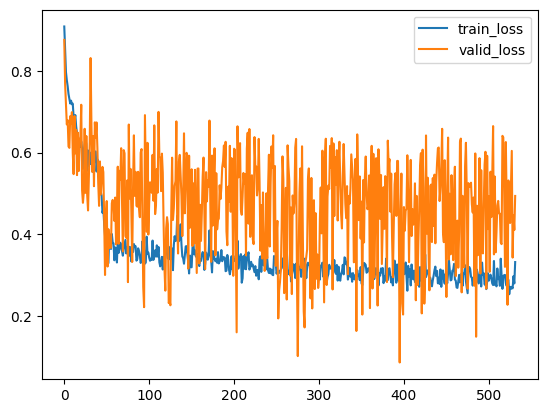

In [13]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

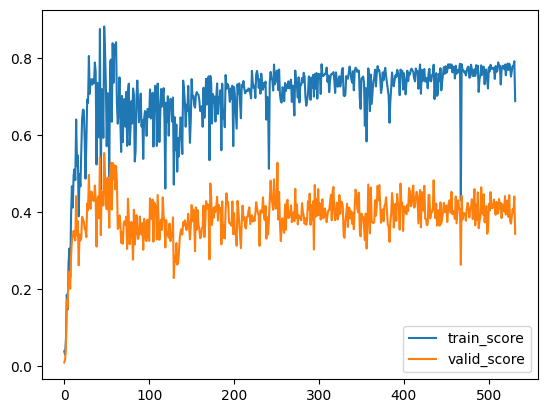

In [14]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [ ]:
random.random()